In [65]:
import numpy as np
import cvxpy as cp
import pickle
from scipy.optimize import linprog
from scipy.spatial import ConvexHull
from torch import Tensor
import sys
sys.path.append("../")
import src.lcvx as lc
from src.visualization import *
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load lander config

In [13]:
data = np.load('../saved/controllable_set/data.npy')
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

## Construct feasible initial condition

In [17]:
data = np.load('../saved/controllable_set/data.npy')
indices = [2, 3, 5, 6, 7]  # alt, vx, vz, m0, tgo
data_5d = data[:, indices]
data_bounds = (np.min(data_5d, axis=0), np.max(data_5d, axis=0))
data_normalized = (data_5d - data_bounds[0]) / (data_bounds[1] - data_bounds[0])
hull_5d = ConvexHull(data_normalized, qhull_options='Q12')

In [26]:
# print data bounds
print('data bounds:')
print(data_bounds[0])
print(data_bounds[1])

data bounds:
[   9.99999995    0.         -100.00000003 1527.04114659    8.84210526]
[1695.10526321   57.56496496   90.90156279 1904.60032772  150.        ]


In [151]:
# fix altitude and mass. solve for bounds on velocity (x and z) and tgo
alt = 1500.0 
mass = 1800.0
lander.mwet = mass

alt_normalized = (alt - data_bounds[0][0]) / (data_bounds[1][0] - data_bounds[0][0])
mass_normalized = (mass - data_bounds[0][3]) / (data_bounds[1][3] - data_bounds[0][3])

A_ub = hull_5d.equations[:, :-1]
b_ub = -hull_5d.equations[:, -1]
A_eq = np.array([[1, 0, 0, 0, 0], [0, 0, 0, 1, 0]])
b_eq = np.array([alt_normalized, mass_normalized])

maxs = []
mins = []
for i in [1, 2, 4]:
    c = np.zeros(5)
    c[i] = 1
    sol = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq).fun
    # denormalize
    sol = sol * (data_bounds[1][i] - data_bounds[0][i]) + data_bounds[0][i]
    mins.append(sol)
    sol = linprog(-c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq).fun
    sol = sol * (data_bounds[1][i] - data_bounds[0][i]) + data_bounds[0][i]
    maxs.append(-sol)


print('vx: [{}, {}]'.format(mins[0], maxs[0]))
print('vz: [{}, {}]'.format(mins[1], maxs[1]))
print('tgo: [{}, {}]'.format(mins[2], maxs[2]))


vx: [0.0, 54.36129765824233]
vz: [-100.00000003363719, 247.1546724842325]
tgo: [30.448917905619265, 97.0805909763303]


In [153]:
N = 100
tf = 60.0
x0 = np.array([0, 0, alt, -30.0, 0, -55.0, np.log(mass)])

In [154]:
# Define the problem
lcvx = lc.LCvxMinFuel(
        rocket=lander,
        N=N,
        parameterize_x0=False,
        parameterize_tf=False,
        fixed_target=False,
    )
prob = lcvx.problem(x0=x0, tf=tf)
prob.solve(solver=cp.ECOS, verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 28 05:54:10 PM: Your problem has 1107 variables, 410 constraints, and 0 parameters.
(CVXPY) Nov 28 05:54:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 28 05:54:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 28 05:54:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 28 05:54:10 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 28 05:54:10 PM: Compiling problem (target solver=ECOS).


281.3113264733277

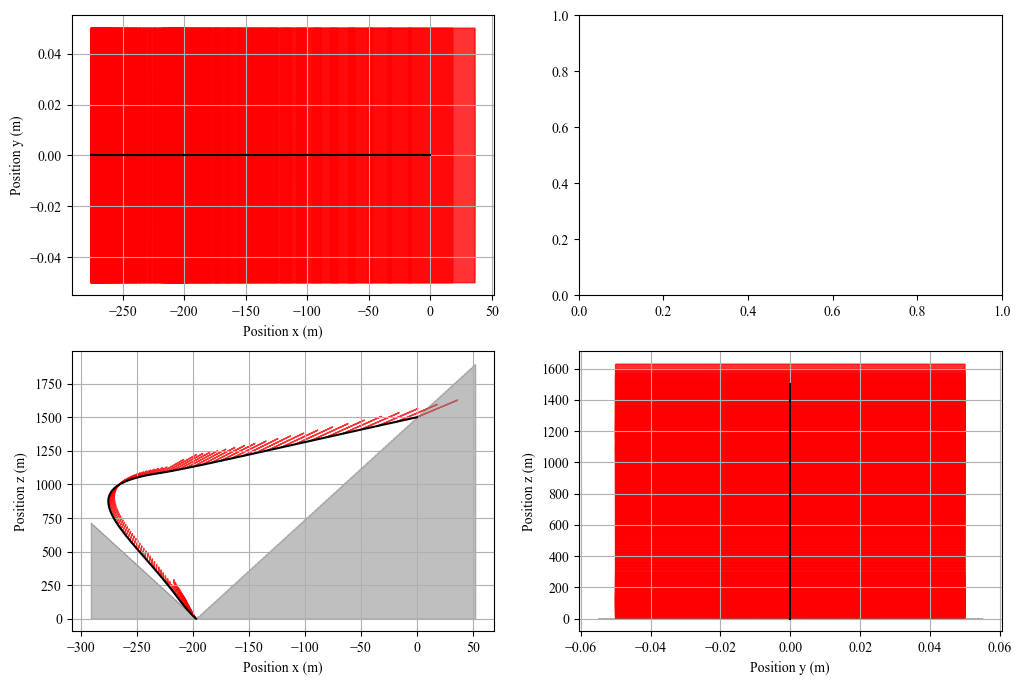

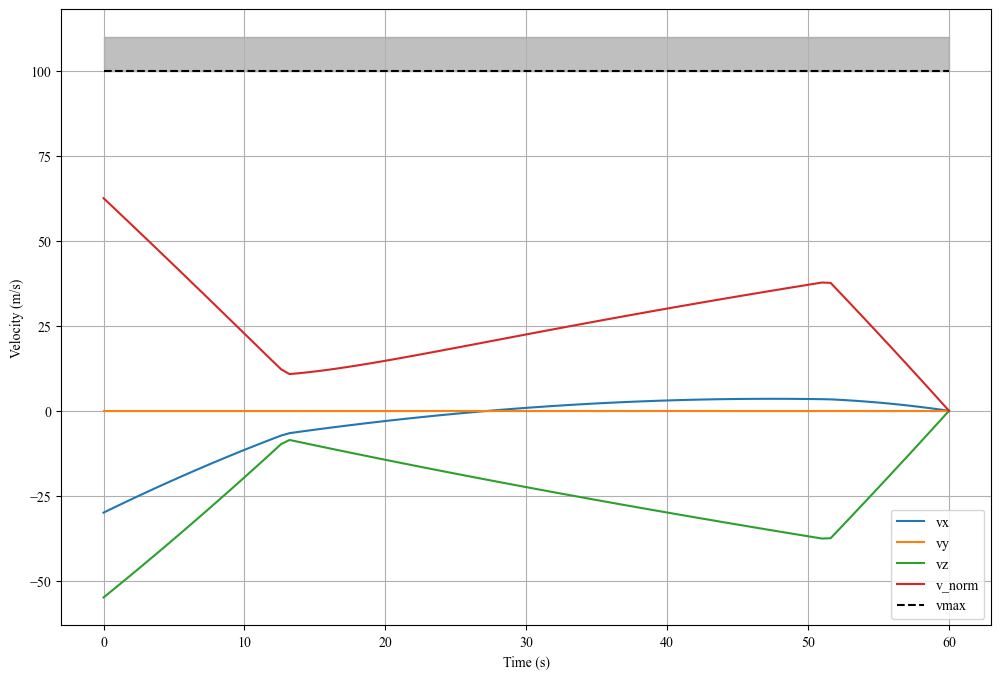

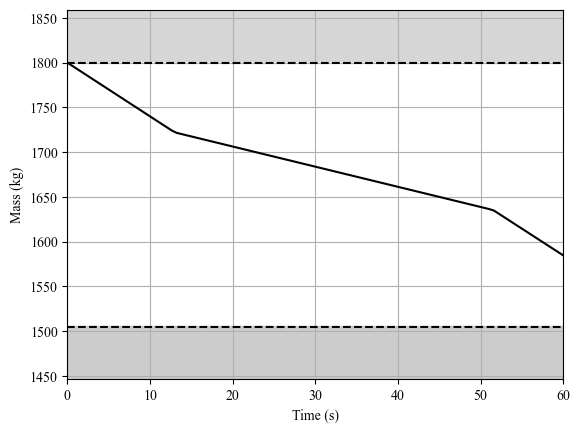

(100,)


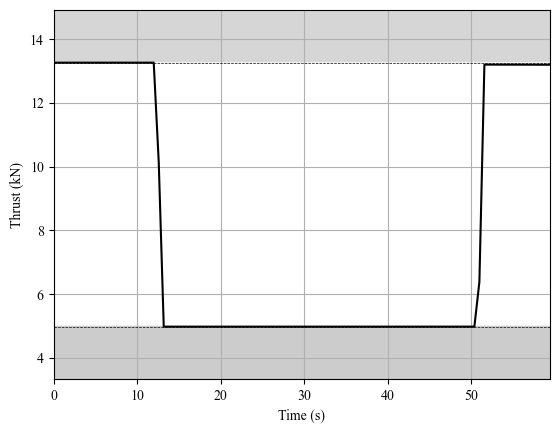

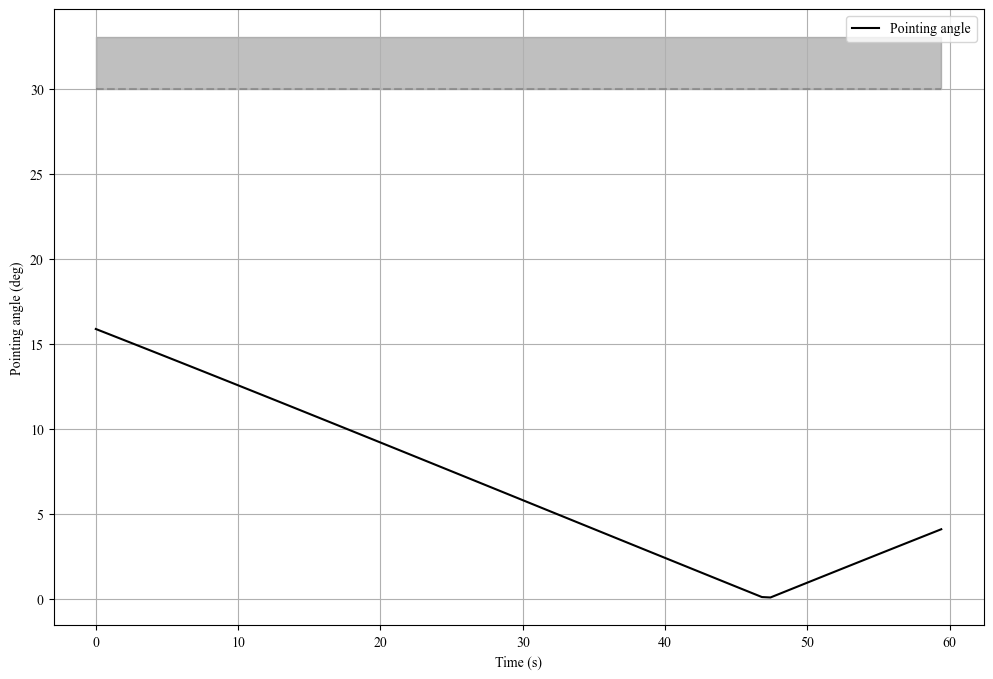

In [155]:
sol = lc.get_vars(prob, ["X", "U"])
X_sol = sol["X"]
U_sol = sol["U"]
r, v, z, u, sigma = lcvx.recover_variables(X_sol, U_sol)

# visualize
m = np.exp(z)
X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
U = u.T * m[:-1].reshape(-1, 1)

# Plot results
t = np.linspace(0, tf, lcvx.N + 1)
plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)

plot_vel(t, X, lander.vmax)

plot_mass(t, X, lander.mdry, lander.mwet)

plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)

plot_pointing(t[:-1], U, lander.pa)

## NN Reachability

In [41]:
import src.learning as lrn
import torch

In [45]:
import torch.nn as nn 
class ConvexNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        """
        Initialize the modified neural network.

        :param input_dim: Number of input dimensions.
        :param output_dim: Number of output dimensions.
        :param hidden_layers: List containing the number of neurons in each hidden layer.
        """
        super(ConvexNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers.append(output_dim)

        # Main layers from previous hidden layer
        self.main_layers = nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            linear = nn.Linear(prev_dim, hidden_dim)
            if prev_dim != input_dim:  # Apply positivity constraint only to layers after the first
                with torch.no_grad():
                    linear.weight.clamp_(min=0)
            self.main_layers.append(linear)
            prev_dim = hidden_dim

        # Additional layers from the original input
        self.additional_layers = nn.ModuleList()
        for hidden_dim in hidden_layers[1:]:  # Skip first layer as it directly connects to input
            linear = nn.Linear(input_dim, hidden_dim)
            with torch.no_grad():
                linear.weight.clamp_(min=0)
            self.additional_layers.append(linear)

        # Output layer
        self.output_layer = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        for i, main_layer in enumerate(self.main_layers):
            x_main = main_layer(x if i == 0 else output)

            # Apply additional layer if not the first hidden layer
            if i > 0:
                x_additional = self.additional_layers[i-1](x)
                output = nn.ReLU()(x_main + x_additional)
            if i == len(self.main_layers) - 1:
                output = x_main
            else:
                output = nn.ReLU()(x_main)

        return output
    
    def clamp_weights(self):
        """
        Ensure that the weights remain positive after training updates, except for the first layer.
        """
        for i, layer in enumerate(self.main_layers):
            if i > 0 and isinstance(layer, nn.Linear):  # Skip the first layer
                with torch.no_grad():
                    layer.weight.clamp_(min=0)
            #if i < len(self.additional_layers) and isinstance(self.additional_layers[i], nn.Linear):
            #    with torch.no_grad():
            #        self.additional_layers[i].weight.clamp_(min=0)

# Example usage
modified_model = ConvexNN(input_dim=10, output_dim=5, hidden_layers=[20, 30])
print(modified_model)

ConvexNN(
  (main_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=5, bias=True)
  )
  (additional_layers): ModuleList(
    (0): Linear(in_features=10, out_features=30, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (output_layer): Linear(in_features=5, out_features=5, bias=True)
)


In [59]:
class NeuralReachCvx(ConvexNN):
    def __init__(self, hidden_layers):
        input_dim = 5  # alt, vx, vz, z, tgo
        output_dim = 4  # xmin, xmax, ymax, x-ymax
        super(NeuralReachCvx, self).__init__(
            input_dim,
            output_dim,
            hidden_layers,
        )

    def forward(self, x):
        out = super(NeuralReachCvx, self).forward(x)
        # change sign of first (xmin) and third (ymax) output to ensure convexity
        out[:, [1, 2]] = -out[:, [1, 2]]
        return out

In [60]:
model = NeuralReachCvx(hidden_layers=[256, 256, 256]).double()
# load model from file
model.load_state_dict(torch.load('../saved/controllable_set/reachset_train/models_20231128-154753/cvx_model.pth'))
model.eval()

NeuralReachCvx(
  (main_layers): ModuleList(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=4, bias=True)
  )
  (additional_layers): ModuleList(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): Linear(in_features=5, out_features=256, bias=True)
    (2): Linear(in_features=5, out_features=4, bias=True)
  )
  (output_layer): Linear(in_features=4, out_features=4, bias=True)
)

## Reachable Set Model

In [233]:
def make_simple_sfmap(x_range, y_range, n_points, dtype='float32'):
    """Make safety map from scratch"""

    xmin, xmax = x_range
    ymin, ymax = y_range
    x = np.linspace(xmin, xmax, n_points)
    y = np.linspace(ymin, ymax, n_points)
    X, Y = np.meshgrid(x, y)

    sfmap = np.zeros((n_points, n_points, 3))
    sfmap[:, :, 0] = X
    sfmap[:, :, 1] = Y
    sfmap[:, :, 2] = X + Y 
    sfmap[:, :, 2] = (sfmap[:, :, 2] - np.min(sfmap[:, :, 2])) / (np.max(sfmap[:, :, 2]) - np.min(sfmap[:, :, 2]))
    sfmap[:, :, 2][X > 500] = 0.0
    sfmap[:, :, 2][Y > 500] = 0.0
    sfmap[:, :, 2][X < -500] = 0.0
    sfmap[:, :, 2][Y < -500] = 0.0
    

    sfmap = sfmap.reshape(-1, 3)
    if dtype == 'float32':
        sfmap = torch.from_numpy(sfmap).float()
    elif dtype == 'float64':
        sfmap = torch.from_numpy(sfmap).double()
    else:
        raise ValueError('dtype must be either float32 or float64')
    
    return sfmap, (n_points, n_points)


In [66]:
def rot2d_torch(theta: Tensor):
    """2D rotation matrix.

    Args:
        theta (Tensor): angle of rotation (rad)

    Returns:
        Tensor: 2D rotation matrix
    """
    return torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])


In [92]:
from src.learning import transform_ic, inverse_transform_reachsetparam

def get_nn_reachset_param(x0: Tensor, tgo: Tensor, model: nn.Module, fov: float):
    """Compute parameters of soft landing reachable set using NN model"""

    assert x0.shape == (7,), f"Invalid shape of x0: {x0.shape}"


    # unpack state
    r, v, z = x0[:3], x0[3:6], x0[6]
    alt = r[2]
    v_horiz = torch.norm(v[:2])
    v_vert = v[2]
    v_horiz_angle = torch.atan2(v[1], v[0])

    # prepare input
    alt_, v_horiz_, v_vert_, z_, tgo_ = transform_ic(alt, v_horiz, v_vert, z, tgo)
    nn_input = torch.tensor([alt_, v_horiz_, v_vert_, z_, tgo_])
    nn_input = nn_input.unsqueeze(0)

    # check model dtype and convert input accordingly
    model_dtype = next(model.parameters()).dtype
    if model_dtype == torch.float64:
        nn_input = nn_input.double()
    elif model_dtype == torch.float32:
        nn_input = nn_input.float()
    else:
        raise TypeError(f"Model dtype {model_dtype} not supported.")

    # compute output (= reachset parameters)
    nn_output = model(nn_input)
    nn_output = nn_output.squeeze(0)
    xmin_, xmax_, ymax_, x_ymax_ = nn_output
    xmin, xmax, ymax, x_ymax = inverse_transform_reachsetparam(xmin_, xmax_, ymax_, x_ymax_, alt, fov=fov)

    return xmin, xmax, ymax, x_ymax, v_horiz_angle, r[:2]


In [150]:
from src.learning import FOV
def reachable_sfmap_soft(x0: torch.Tensor, tgo: torch.Tensor, model: nn.Module, sfmap: torch.Tensor, alpha=1.0, fov=FOV):
    """Compute safety map indices of reachable set with a soft boundary; differentiable.

    Args:
        x0 (torch.Tensor): initial state
        tgo (torch.Tensor): time to go
        model (nn.Module): NN model
        sfmap (torch.Tensor): safety map, [[x, y, safety], ...]], shape (n, 3)
        alpha (float, optional): soft boundary parameter. Defaults to 1.0.

    Returns:
        soft_mask (torch.Tensor): soft boundary mask, shape (n, )
    """
    eps = 1e-8  # small constant to prevent numerical instability

    # compute reachset parameters
    xmin, xmax, ymax, x_ymax, rotation_angle, center = get_nn_reachset_param(x0, tgo, model, fov)
    a1 = x_ymax - xmin
    a2 = xmax - x_ymax
    b = ymax
    
    # shift and rotate safety map to canonical coordinate of reachset
    _xy = rot2d_torch(-rotation_angle) @ (sfmap[:, :2] - center).T
    _xy = _xy.T
    _x = _xy[:, 0]
    _y = _xy[:, 1]

    # compute soft boundary
    mask0 = torch.sigmoid(alpha * (x_ymax - _x))  # 1 for x < x_ymax, 0 for x >= x_ymax
    mask1 = torch.sigmoid(alpha * (1 - (_x - x_ymax)**2 / (a1**2 + eps) - _y**2 / (b**2 + eps)))
    mask2 = torch.sigmoid(alpha * (1 - (_x - x_ymax)**2 / (a2**2 + eps) - _y**2 / (b**2 + eps)))
    soft_mask = torch.max(torch.min(mask1, mask0), torch.min(mask2, 1 - mask0))

    # filter out points outside of the field of view
    fov_radius = x0[2] * torch.tan(fov / 2)
    fov_mask = torch.sigmoid(alpha * (fov_radius**2 - (_x)**2 - (_y)**2))  # center is at (0, 0) because we already shifted the safety map
    soft_mask_fov = torch.min(soft_mask, fov_mask)

    return soft_mask_fov

In [237]:
def ic2mean_safety(x0: torch.Tensor, tgo: torch.Tensor, model: nn.Module, sfmap: torch.Tensor, border_sharpness=0.1, fov=FOV):
    """Compute mean safety of the initial condition (x0, tgo) based on the soft landing reachable set.

    Args:
        x0 (torch.Tensor): initial state
        tgo (torch.Tensor): time to go
        model (nn.Module): NN model
        sfmap (torch.Tensor): safety map, [[x, y, safety], ...]], shape (n, 3)
        border_sharpness (float, optional): sharpness of reachable set border. Defaults to 0.1.
        fov (float, optional): field of view. Defaults to FOV.

    Returns:
        mean_safety (torch.Tensor): mean safety, shape (1, )
        sfmap_reachable_mask (torch.Tensor): reachable safety map mask, shape (n, )
    """

    # compute reachable safety map
    sfmap_reachable_mask = reachable_sfmap_soft(x0, tgo, model, sfmap, alpha=border_sharpness, fov=fov)

    # compute mean safety
    mean_safety = torch.sum(sfmap[:, 2] * sfmap_reachable_mask) / torch.sum(sfmap_reachable_mask + 1e-8)  # added epsilon for numerical stability

    return mean_safety, sfmap_reachable_mask

def u_2mean_safety(u_: Tensor, tgo_next: Tensor, x0: Tensor, dt: float, rocket: nn.Module, sfmap: Tensor, model: nn.Module, fov: Tensor, border_sharpness: float = 1.0):
    """Return mean safety and reachable mask for the control sequence.

    Args:
        u_ (torch.Tensor): normalized control sequence, shape (N, 3)
        tgo_next (torch.Tensor): time to go at the next waypoint, shape (N, )
        x0 (torch.Tensor): initial state, shape (7, )
        dt (float): time step
        rocket (nn.Module): rocket model
        sfmap (torch.Tensor): safety map, [[x, y, safety], ...]], shape (n, 3)

    Returns:
        mean_safety (torch.Tensor): mean safety
        reachable_mask (torch.Tensor): reachable mask, shape (N, )
    """
    # propagate dynamics
    x = u_2x(u_, x0, dt, rocket)
    
    # compute mean safety on the reachable safety map
    mean_safety, reachable_mask = ic2mean_safety(x, tgo_next, model, sfmap, border_sharpness, fov)
    
    return mean_safety, reachable_mask


def u_2x(u_: Tensor, x0: Tensor, dt: float, rocket: nn.Module):
    """Propagate dynamics with the normalized control sequence.

    Args:
        u_ (torch.Tensor): normalized control sequence, shape (N, 3)
        x0 (torch.Tensor): initial state, shape (7, )
        dt (float): time step
        rocket (nn.Module): rocket model
    
    Returns:
        x (torch.Tensor): propagated states, shape (N, 7)
    """
    #x = x0
    # copy x0 tensor to avoid in-place operation
    x = x0.clone()
    for i in range(u_.shape[0]):
        u = inverse_transform_u(u_[i], torch.tensor(rocket.rho1), torch.tensor(rocket.rho2), torch.tensor(rocket.pa))
        x = dynamics(x, u, dt, torch.tensor(rocket.g), torch.tensor(rocket.alpha))
    return x



def dynamics(x: torch.Tensor, u: torch.Tensor, dt: float, g: torch.Tensor, alpha: float):
    """Compute next state under rocket dynamics. 

    Args:
        x (torch.Tensor): state, shape (7, ); [x, y, z, vx, vy, vz, log(mass)]
        u (torch.Tensor): control, shape (3, )
        dt (float): time step
        g (torch.Tensor): gravity, shape (3, )
        alpha (float): mass flow rate

    Returns:
        x_ (torch.Tensor): next state, shape (7, )
    """
    mass = torch.exp(x[6])
    dt22 = dt **2 / 2.0
    x_ = torch.zeros_like(x)
    x_[:3] = x[:3] + dt * x[3:6] + dt22 * (u/mass + g)
    x_[3:6] = x[3:6] + dt * (u/mass + g)
    x_[6] = x[6] - dt * alpha * torch.norm(u) / mass
    return x_

def inverse_transform_u(u_: Tensor, rho1: Tensor, rho2: Tensor, pa: Tensor):
    """Inverse transform: from normalized thrust vector u_ to thrust vector u.

    Args:
        u_ (torch.Tensor): normalized control parameter, [0, 1], shape (3, )
            - u_[0] is the normalized norm of u
            - u_[1] is the normalized x element
            - u_[2] is the normalized y element
        rho1 (Tensor): minimum thrust
        rho2 (Tensor): maximum thrust
        pa (Tensor): maximum gimbal angle
    
    Returns:
        torch.Tensor: control, shape (3, )
    """
    assert u_.shape == (3,), "Invalid shape of u_: {}".format(u_.shape)

    eps = 1e-8
    u = torch.zeros(3)
    
    u_norm = u_[0] * (rho2 - rho1) + rho1
    
    R = u_norm * torch.sin(pa)  # radius of the the circle that intersects |u|==u_norm sphere and angle(u, uz)==pa
    u_xy_ = (u_[:2] * 2 - 1) * R  # u_xy_ lies on the [-R, R] square 
    u_xy_norm = torch.norm(u_xy_)  
    u_xy_norm_clamped = torch.clamp(u_xy_norm, torch.tensor(0.), R)  # u_xy_norm_clamped is bounded by [0, R]
    u[:2] = u_xy_ * u_xy_norm_clamped / (u_xy_norm+eps)  # u_xy lies inside the circle with radius R
    u[2] = torch.sqrt(u_norm**2 - u_xy_norm_clamped**2)  # u_z is determined by u_norm and u_xy

    return u


def transform_u(u: Tensor, rho1: Tensor, rho2: Tensor, pa: Tensor):
    """Transform thrust vector u to normalized thrust vector u_.
    
    Args:
        u (torch.Tensor): control, shape (3, )
        rho1 (Tensor): minimum thrust
        rho2 (Tensor): maximum thrust
        pa (Tensor): maximum gimbal angle
    
    """
    u_ = torch.zeros(3)
    u_norm = torch.norm(u)
    u_xy_norm = torch.norm(u[:2])
    pa_num = torch.atan2(u_xy_norm, u[2])
    assert u_norm >= rho1 and u_norm <= rho2, "u_norm {} is out of range: [{}, {}]".format(u_norm, rho1, rho2)
    assert pa_num <= pa, "pa_num is out of range"

    u_[0] = (u_norm - rho1) / (rho2 - rho1)
    u_[:2] = (u[:2] / u_xy_norm + 1) / 2

    return u_

In [171]:
def visualize_nn_reachset(reach_mask: Tensor, sfmap: Tensor, nskip: int = 20):
    reach_mask_ = reach_mask.clone()
    reach_mask_ = reach_mask_.detach().cpu().numpy()
    sfmap_ = sfmap.clone()
    sfmap_ = sfmap_.detach().cpu().numpy()

    rm = reach_mask_[::nskip]
    sf = sfmap_[::nskip]

    fig, ax = plt.subplots()

    ax.scatter(sf[:, 0], sf[:, 1], c=rm, s=0.5, cmap="jet", alpha=0.5)
    ax.scatter(sf[:, 0], sf[:, 1], c=sf[:, 2], s=0.5, cmap="gray", alpha=0.3)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.grid(True)
    plt.show()



def visualize_results(u_, tgo_next, x0, dt, sfmap, model, rocket, border_sharpness, fov):

    # copy x0 tensor to avoid in-place operation
    x = x0.clone()
    for i in range(u_.shape[0]):
        u = inverse_transform_u(u_[i], torch.tensor(rocket.rho1), torch.tensor(rocket.rho2), torch.tensor(rocket.pa))
        x = dynamics(x, u, dt, torch.tensor(rocket.g), torch.tensor(rocket.alpha))

    mean_safety, reach_mask = ic2mean_safety(x, tgo_next, model, sfmap, border_sharpness=border_sharpness, fov=fov)
    print(f'x: {x}, tgo: {tgo_next}, mean safety: {mean_safety}')
    
    visualize_nn_reachset(reach_mask, sfmap, nskip=10)

In [73]:
from scipy.optimize import basinhopping

def basinhopping_torch(f: callable, x0: torch.Tensor, bounds: list=None, niter: int = 100, verbose: bool = False):
    """Minimize function f using scipy.optimize.basinhopping

    Args:
        f (callable): function compatible with Pytorch AD 
        x0 (torch.Tensor): initial guess. Must be a 1D array
        bounds (list): bounds for x, tuple of (min, max) pairs for each element in x. Example: [(0,1), (0,1), (0,1)] or [(0, 1)] for abbreviate form
        niter (int, optional): number of iterations. Defaults to 100.
    """
    shape = x0.shape
    assert len(shape) == 1, "x0 must be a 1D array"

    # Convert bounds to a list of tuples
    if bounds is not None and len(bounds) == 1:
        bounds = bounds * shape[0]

    def f_np(x):
        x_torch = torch.from_numpy(x).double()
        x_torch.requires_grad = False
        return f(x_torch).item()

    def df_np(x):
        x_torch = torch.from_numpy(x).double()
        x_torch.requires_grad = True
        y_torch = f(x_torch)
        y_torch.backward()
        return x_torch.grad.detach().numpy()
    
    if bounds is None:
        res = basinhopping(f_np, x0.detach().numpy(), niter=niter, minimizer_kwargs={"method": "L-BFGS-B", "jac": df_np}, disp=verbose)
    else:
        res = basinhopping(f_np, x0.detach().numpy(), niter=niter, minimizer_kwargs={"method": "L-BFGS-B", "jac": df_np, "bounds": bounds}, disp=verbose)
    return torch.Tensor(res.x)

In [238]:

sfmap, _ = make_simple_sfmap(x_range=(-1000, 1000), y_range=(-1000, 1000), n_points=1000)

x: tensor([   0.0000,    0.0000, 1500.0000,  -30.0000,    0.0000,  -55.0000,
           7.4955], dtype=torch.float64), tgo: 60.0, mean safety: 0.48456018389354155


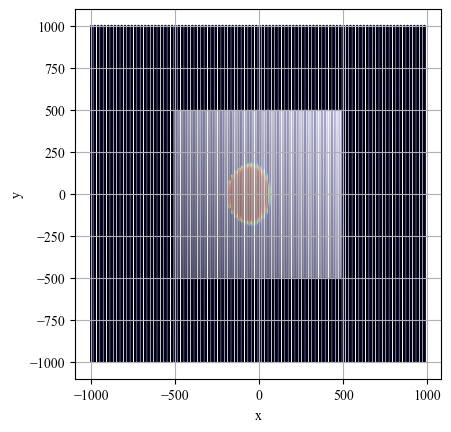

In [242]:
x0_torch = torch.from_numpy(x0).double()
#x0_torch = torch.from_numpy(np.array([-3.0000e-03, -4.8830e-09,  1.5000e+03, -3.0000e+01, -9.7659e-05, -5.5000e+01,  7.4953e+00])).double()
tgo = tf
mean_safety, reach_mask = ic2mean_safety(x0_torch, tgo, model, sfmap, border_sharpness=10, fov=torch.tensor(lander.fov))
print(f'x: {x0_torch}, tgo: {tgo}, mean safety: {mean_safety}')
visualize_nn_reachset(reach_mask, sfmap, nskip=10)


- infeasibleness is also a convex function
- training data for infeasibleness should be computed easily with convex hull 
  - outway distance to the convex hull surface
- reachability steering must also minimize infeasibleness 
  - boundary computation is the problem!

basinhopping step 0: f -0.442347
basinhopping step 1: f -0.464601 trial_f -0.464601 accepted 1  lowest_f -0.464601
found new global minimum on step 1 with function value -0.464601
basinhopping step 2: f -0.476436 trial_f -0.476436 accepted 1  lowest_f -0.476436
found new global minimum on step 2 with function value -0.476436
basinhopping step 3: f -0.47654 trial_f -0.47654 accepted 1  lowest_f -0.47654
found new global minimum on step 3 with function value -0.47654
x: tensor([-116.9793,   32.3509, 1258.6755,  -16.7831,   13.0025,  -41.4436,
           7.4787], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 55.0, mean safety: 0.47653985352704853


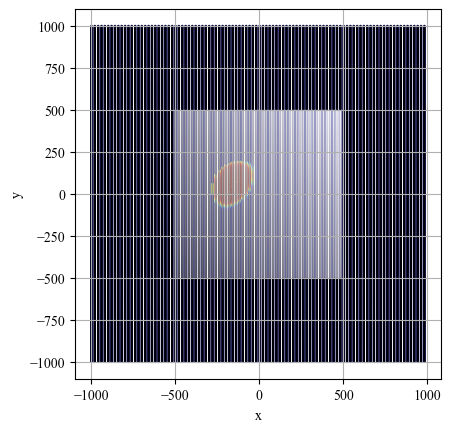

basinhopping step 0: f -0.461586
basinhopping step 1: f -0.461635 trial_f -0.461635 accepted 1  lowest_f -0.461635
found new global minimum on step 1 with function value -0.461635
basinhopping step 2: f -0.500497 trial_f -0.500497 accepted 1  lowest_f -0.500497
found new global minimum on step 2 with function value -0.500497
basinhopping step 3: f -0.500905 trial_f -0.500905 accepted 1  lowest_f -0.500905
found new global minimum on step 3 with function value -0.500905
x: tensor([-162.2382,  123.8492, 1086.4954,   -1.3776,   23.6803,  -27.3392,
           7.4616], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 50.0, mean safety: 0.5009053118119481


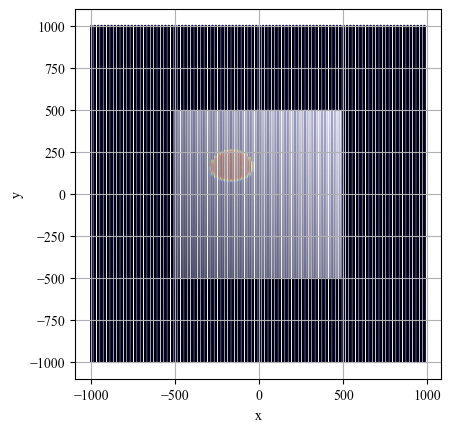

basinhopping step 0: f -0.517897
basinhopping step 1: f -0.539124 trial_f -0.539124 accepted 1  lowest_f -0.539124
found new global minimum on step 1 with function value -0.539124
basinhopping step 2: f -0.539276 trial_f -0.539276 accepted 1  lowest_f -0.539276
found new global minimum on step 2 with function value -0.539276
basinhopping step 3: f -0.542679 trial_f -0.542679 accepted 1  lowest_f -0.542679
found new global minimum on step 3 with function value -0.542679
x: tensor([-138.3423,  258.0491,  975.8337,   10.5281,   30.7355,  -16.8506,
           7.4464], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 45.0, mean safety: 0.5426792439867779


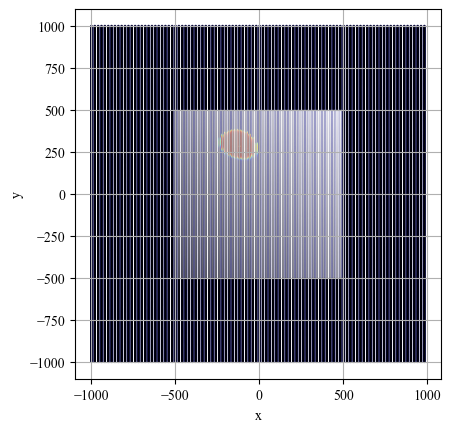

basinhopping step 0: f -0.595343
basinhopping step 1: f -0.595621 trial_f -0.595621 accepted 1  lowest_f -0.595621
found new global minimum on step 1 with function value -0.595621
basinhopping step 2: f -0.595501 trial_f -0.595501 accepted 1  lowest_f -0.595621
basinhopping step 3: f -0.595579 trial_f -0.595579 accepted 1  lowest_f -0.595621
x: tensor([-50.0890, 379.2145, 928.8718,  23.9741,  17.4389,  -2.4551,   7.4292],
       dtype=torch.float64, grad_fn=<CopySlices>), tgo: 40.0, mean safety: 0.5956207927600986


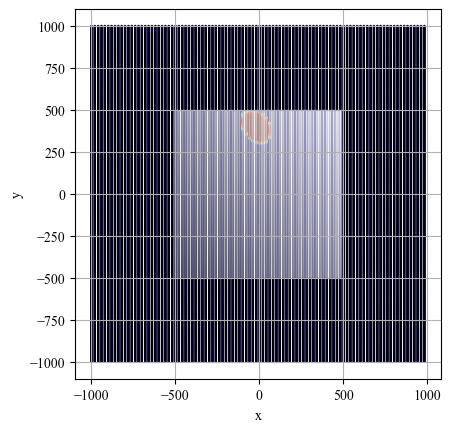

basinhopping step 0: f -0.55345
basinhopping step 1: f -0.553258 trial_f -0.553258 accepted 1  lowest_f -0.55345
basinhopping step 2: f -0.552871 trial_f -0.552871 accepted 1  lowest_f -0.55345
basinhopping step 3: f -0.553398 trial_f -0.553398 accepted 1  lowest_f -0.55345
x: tensor([ 91.6750, 429.3269, 944.7912,  32.7448,   2.5681,   8.8911,   7.4136],
       dtype=torch.float64, grad_fn=<CopySlices>), tgo: 35.0, mean safety: 0.5534500514550558


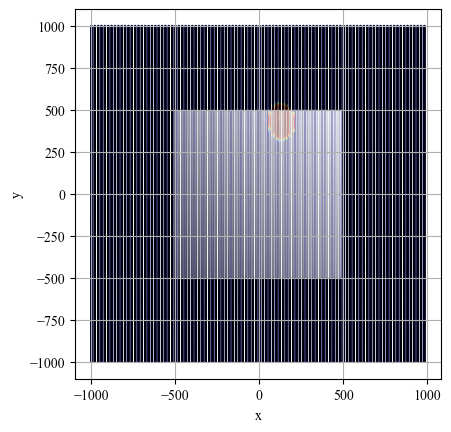

basinhopping step 0: f -0.662954
basinhopping step 1: f -0.662548 trial_f -0.662548 accepted 1  lowest_f -0.662954
basinhopping step 2: f -0.664147 trial_f -0.664147 accepted 1  lowest_f -0.664147
found new global minimum on step 2 with function value -0.664147
basinhopping step 3: f -0.662997 trial_f -0.662997 accepted 1  lowest_f -0.664147
x: tensor([ 277.1313,  404.5063, 1018.2528,   40.7733,  -12.5209,   20.0688,
           7.3980], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 30.0, mean safety: 0.6641470500967182


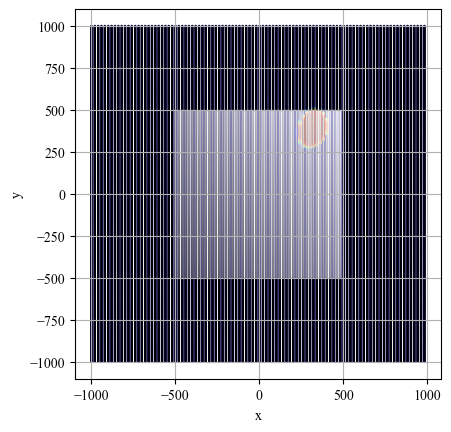

basinhopping step 0: f -0.330261
basinhopping step 1: f -0.331065 trial_f -0.331065 accepted 1  lowest_f -0.331065
found new global minimum on step 1 with function value -0.331065
basinhopping step 2: f -0.329119 trial_f -0.329119 accepted 1  lowest_f -0.331065
basinhopping step 3: f -0.328456 trial_f -0.328456 accepted 1  lowest_f -0.331065
x: tensor([ 462.1652,  336.7156, 1106.4736,   33.3953,  -15.3835,   15.6494,
           7.3906], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 25.0, mean safety: 0.33106510604218


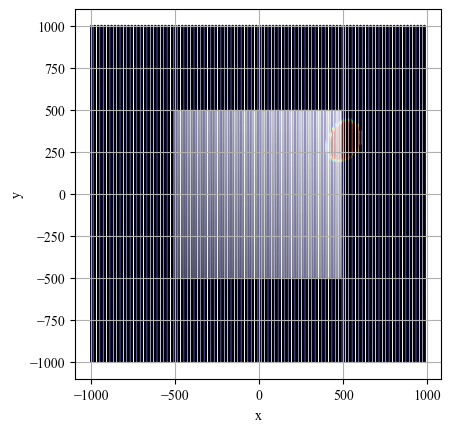

basinhopping step 0: f -5.16012e-07
basinhopping step 1: f -1.29344e-06 trial_f -1.29344e-06 accepted 1  lowest_f -1.29344e-06
found new global minimum on step 1 with function value -1.29344e-06
basinhopping step 2: f -8.15878e-08 trial_f -8.15878e-08 accepted 1  lowest_f -1.29344e-06
basinhopping step 3: f -3.70415e-09 trial_f -3.70415e-09 accepted 1  lowest_f -1.29344e-06
x: tensor([ 615.1832,  244.9840, 1177.0061,   28.2011,  -22.2637,   13.6209,
           7.3821], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 20.0, mean safety: 1.2934389782315527e-06


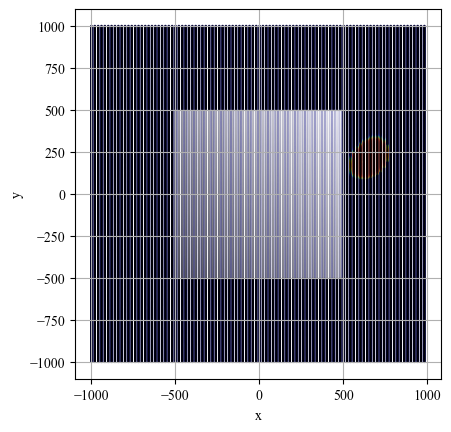

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([ 742.4912,  119.9680, 1232.2700,   22.7159,  -27.7489,    8.4998,
           7.3750], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 15.0, mean safety: 0.0


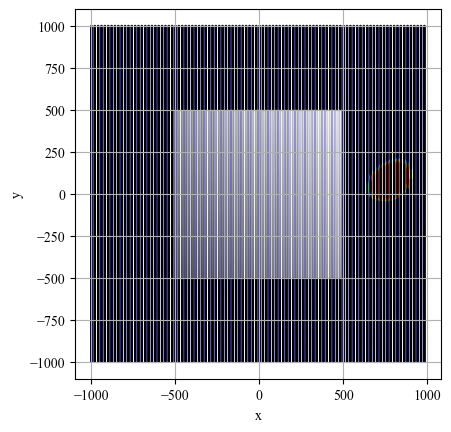

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([ 842.2764,  -32.5708, 1262.1659,   17.1919,  -33.2729,    3.4739,
           7.3679], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 10.0, mean safety: 0.0


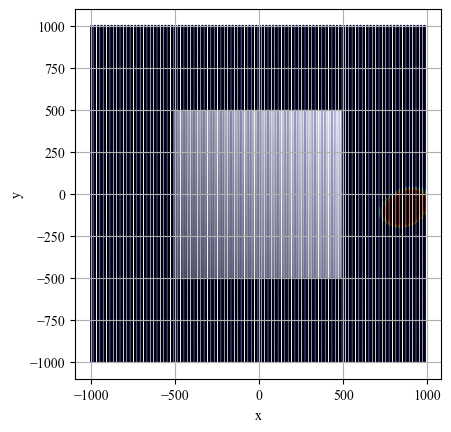

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([ 914.3432, -212.8280, 1267.1725,   11.6285,  -38.8363,   -1.4557,
           7.3608], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 5.0, mean safety: 0.0


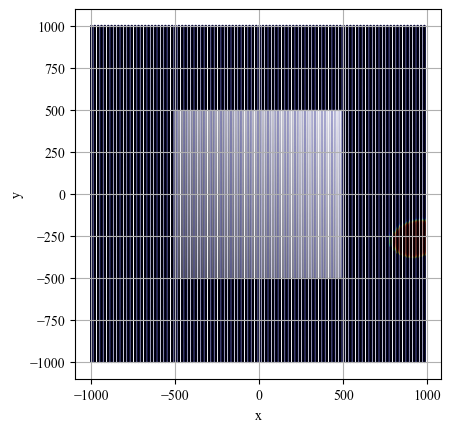

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([ 958.4935, -421.0017, 1247.7754,    6.0252,  -44.4396,   -6.2874,
           7.3536], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 0.0, mean safety: 0.0


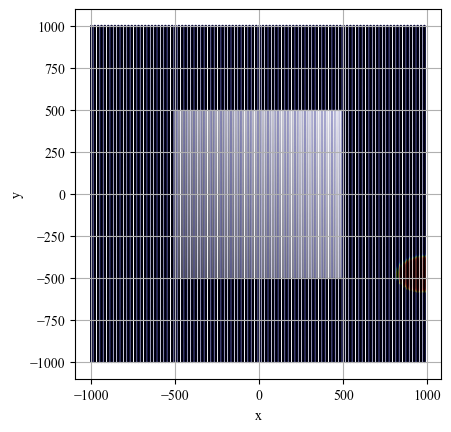

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([ 9.7453e+02, -6.5729e+02,  1.2045e+03,  3.8135e-01, -5.0083e+01,
        -1.1020e+01,  7.3464e+00], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -5.0, mean safety: 0.0


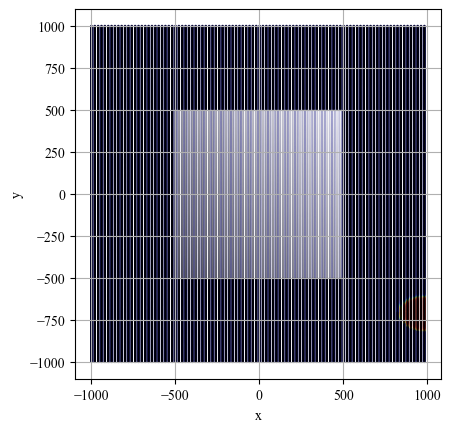

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([ 962.2372, -921.9061, 1137.7475,   -5.3036,  -55.7684,  -15.6517,
           7.3391], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -10.0, mean safety: 0.0


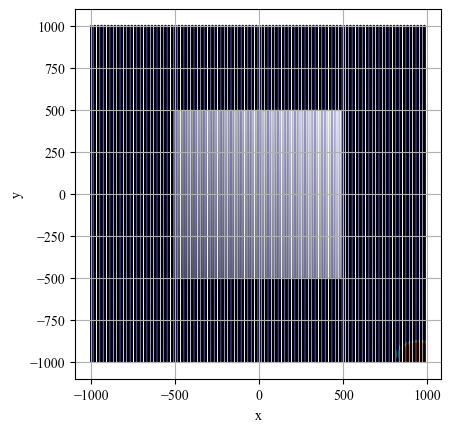

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([  921.4196, -1215.0477,  1048.1235,   -11.0302,   -61.4950,   -20.1814,
            7.3318], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -15.0, mean safety: 0.0


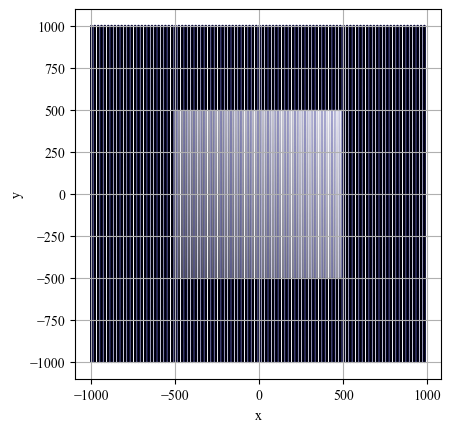

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([  851.8632, -1536.9281,   936.1096,   -16.7992,   -67.2640,   -24.6074,
            7.3244], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -20.0, mean safety: 0.0


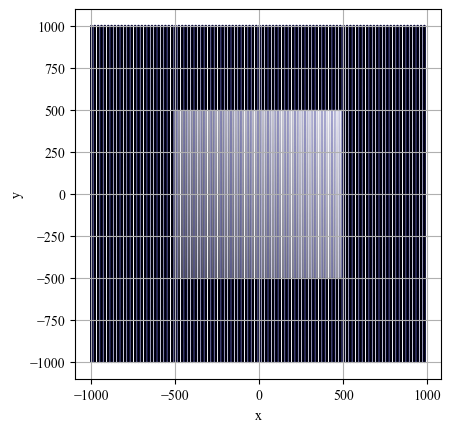

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([  753.3550, -1887.7603,   802.2280,   -22.6110,   -73.0758,   -28.9283,
            7.3169], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -25.0, mean safety: 0.0


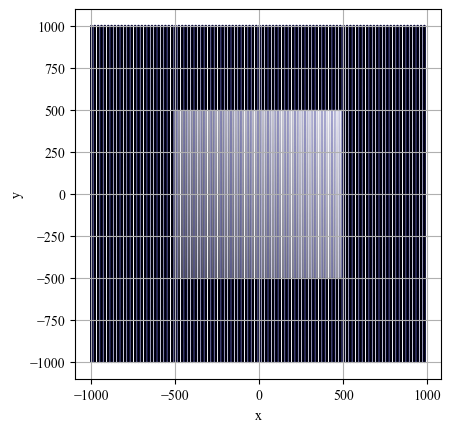

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([  625.6787, -2267.7607,   647.0086,   -28.4665,   -78.9313,   -33.1423,
            7.3094], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -30.0, mean safety: 0.0


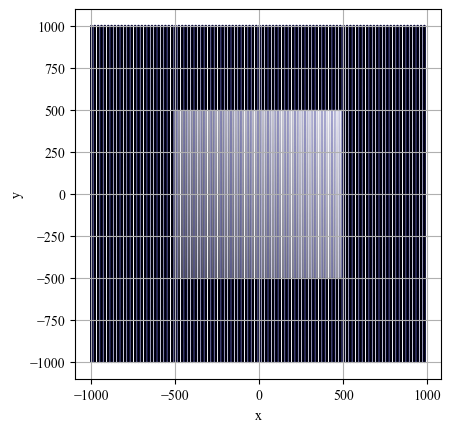

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([  468.6145, -2677.1488,   470.9892,   -34.3663,   -84.8311,   -37.2480,
            7.3018], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -35.0, mean safety: 0.0


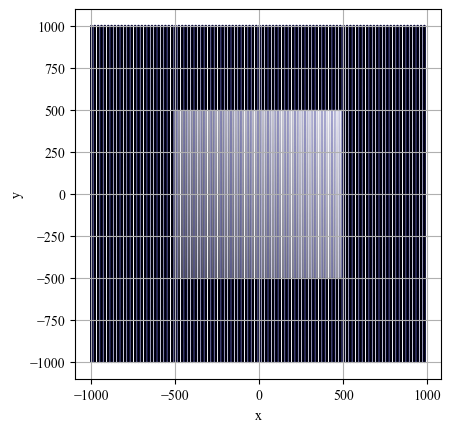

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([  281.9396, -3116.1477,   274.7160,   -40.3109,   -90.7757,   -41.2436,
            7.2942], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -40.0, mean safety: 0.0


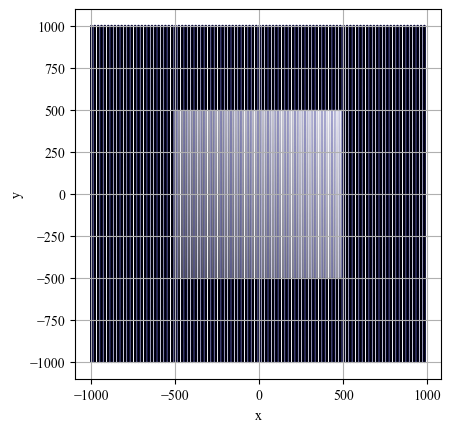

basinhopping step 0: f -0
basinhopping step 1: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 2: f -0 trial_f -0 accepted 1  lowest_f -0
basinhopping step 3: f -0 trial_f -0 accepted 1  lowest_f -0
x: tensor([   65.4277, -3584.9837,    58.7434,   -46.3012,   -96.7660,   -45.1275,
            7.2865], dtype=torch.float64, grad_fn=<CopySlices>), tgo: -45.0, mean safety: 0.0


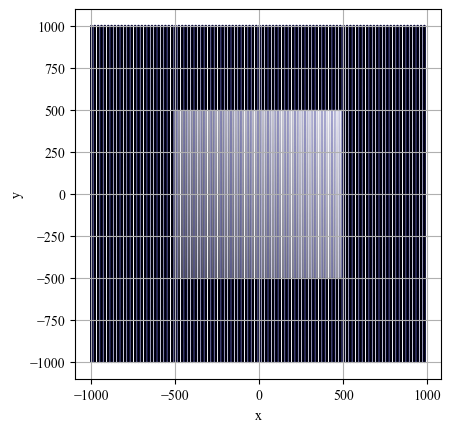

In [243]:
from torch.autograd import Variable

n_horizon = 5
dt = 1.0

sfmap = sfmap.clone().requires_grad_(True)
x0_torch = x0_torch.clone().detach().requires_grad_(True)
tgo_next = torch.tensor(tgo - n_horizon * dt, requires_grad=True)


x_hist = []
u_hist = []
i = 0
while x0_torch[2] > 250:
    u_ = Variable(torch.zeros(n_horizon * 3), requires_grad=True)

    # Make objective function
    def f(u_):
        u_ = u_.reshape(n_horizon, 3)
        mean_safety, _ = u_2mean_safety(
            u_=u_,
            tgo_next=tgo_next,
            x0=x0_torch,
            dt=dt,
            rocket=lander,
            sfmap=sfmap,
            model=model,
            fov=torch.tensor(lander.fov),
            border_sharpness=10
        )
        return -mean_safety
        
    u_opt = basinhopping_torch(f, u_, bounds=[(0., 1.)], niter=3, verbose=True)
    u_opt = u_opt.reshape(n_horizon, 3)
    visualize_results(u_opt, tgo_next, x0_torch, dt, sfmap, model, lander, border_sharpness=10, fov=torch.tensor(lander.fov))

    x0_torch = u_2x(u_opt, x0_torch, dt, lander).clone().detach().requires_grad_(True)
    x_hist.append(x0_torch.detach().numpy())
    u_hist.append(u_opt.detach().numpy())
    tgo_next = torch.tensor(tgo - n_horizon * dt * (i+2), requires_grad=True)

    i += 1



Initial objective: -0.45567622417856024 at u_: tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)
x: tensor([-1.8218e+01, -2.1824e-01,  1.4669e+03, -3.0869e+01, -8.6897e-01,
        -5.5098e+01,  6.1435e+00], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 59.4, mean safety: 0.45567622417932113


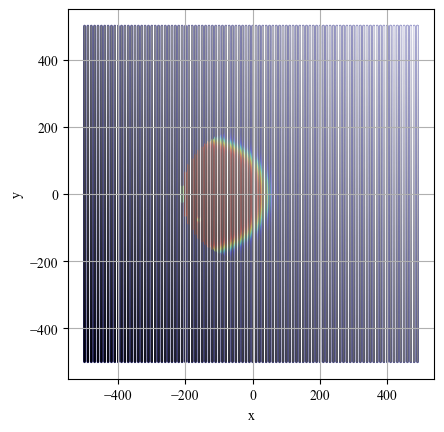

basinhopping step 0: f -0.455676
basinhopping step 1: f -0.455796 trial_f -0.455796 accepted 1  lowest_f -0.455796
found new global minimum on step 1 with function value -0.455796
basinhopping step 2: f -0.456875 trial_f -0.456875 accepted 1  lowest_f -0.456875
found new global minimum on step 2 with function value -0.456875
basinhopping step 3: f -0.456908 trial_f -0.456908 accepted 1  lowest_f -0.456908
found new global minimum on step 3 with function value -0.456908
basinhopping step 4: f -0.456836 trial_f -0.456836 accepted 1  lowest_f -0.456908
basinhopping step 5: f -0.464252 trial_f -0.464252 accepted 1  lowest_f -0.464252
found new global minimum on step 5 with function value -0.464252
basinhopping step 6: f -0.464252 trial_f -0.464252 accepted 1  lowest_f -0.464252
basinhopping step 7: f -0.464252 trial_f -0.464252 accepted 1  lowest_f -0.464252
basinhopping step 8: f -0.464252 trial_f -0.464252 accepted 1  lowest_f -0.464252
basinhopping step 9: f -0.464252 trial_f -0.464252 

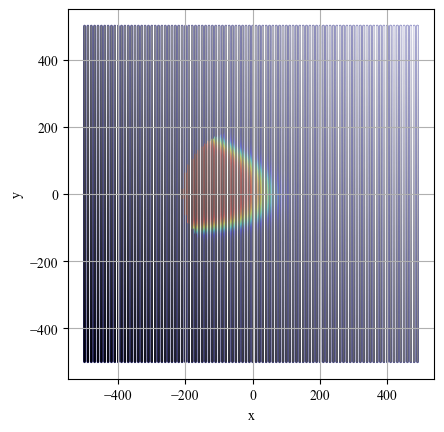

In [183]:
from torch.autograd import Variable
n_horizon = 2
dt = 0.3

# Make objective function
def f(u_):
    u_ = u_.reshape(n_horizon, 3)
    mean_safety, _ = u_2mean_safety(
        u_=u_,
        tgo_next=torch.tensor(tgo - n_horizon * dt).requires_grad_(True),
        x0=x0_torch.requires_grad_(True),
        dt=dt,
        rocket=lander,
        sfmap=sfmap.requires_grad_(True),
        model=model,
        fov=torch.tensor(lander.fov),
        border_sharpness=10
    )
    return -mean_safety

# Initialize variables
u_ = Variable(torch.zeros(n_horizon * 3), requires_grad=True)

# evaluate initial guess
obj0 = f(u_)
print(f"Initial objective: {obj0} at u_: {u_}")
tgo_next = tgo - n_horizon * dt
visualize_results(u_.reshape(n_horizon, 3), tgo_next, x0_torch, dt, sfmap, model, lander, 10, torch.tensor(lander.fov))


# Optimize
#u_opt = gradient_descent(f, u_, bounds=[0., 1.], lr=100., num_epochs=1000, verbose=True)
#u_opt = newton_method(f, u_, bounds=[0., 1.], lr=1., num_epochs=1000, verbose=True)
u_opt = basinhopping_torch(f, u_, bounds=[(0., 1.)], niter=10, verbose=True)
u_opt = u_opt.reshape(n_horizon, 3)

# Evaluate optimal solution
obj_opt = f(u_opt)
print(f"Optimal objective: {obj_opt} at u_opt: {u_opt}")
visualize_results(u_opt.reshape(n_horizon, 3), tgo_next, x0_torch, dt, sfmap, model, lander, 10, torch.tensor(lander.fov))